# FasterR-CNN Inference

## Table of contents
1. [Dataframes import](#df)
2. [Dataset import](#dataset)
3. [Dataloaders](#datal)<br>
    3.1 [Colored images](#col_img)<br>
    3.2 [BW images](#bw_img)<br>
4. [Inference](#inf)<br>
    4.1 [Augmented Model](#aug_m)<br>
    4.2 [BW Model](#bw_m)<br>
    4.3 [Undersampled Model](#under_m)<br>
    4.4 [Oversampled Model](#over_m)<br>
    4.5 [Best VS BW](#bestVSbw)

In [1]:
# importing libraries
import pandas as pd
import json
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sn
import numpy as np
from PIL import Image
import torchvision
from typing_extensions import Concatenate
from torch.utils.data.sampler import Sampler
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations.pytorch
import albumentations
import cv2
import time
import torch
import pickle
from tqdm.notebook import tqdm

## FasterR-CNN Model and Device

In [2]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")  
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 1. Importing Dataframes <a class="anchor" id="df"></a>

In [3]:
file = open("pickles_df/val.pickle", "rb")
val_df_final = pickle.load(file)
file.close()

file = open("pickles_df/test.pickle", "rb")
test_df_final = pickle.load(file)
file.close()

In [4]:
# encoding category to integers
encode_cat_dic = {'Ardea alba': 1,
 'Melospiza melodia': 2,
 'Buteo jamaicensis': 3,
 'Pandion haliaetus': 4,
 'Junco hyemalis': 5,
 'Zenaida macroura': 6,
 'Cardinalis cardinalis': 7,
 'Picoides pubescens': 8,
 'Agelaius phoeniceus': 9,
 'Ardea herodias': 10,
 'Background':11}

In [5]:
enc2cat = {v:k for k,v in encode_cat_dic.items()}

## 2. Dataset Class <a class="anchor" id="datatset"></a>

In [6]:
from SATM.dataset import AvesAugmentationDataset, SATMsampler
from SATM.dataset import collate_fn, generate_box, generate_target, plot_image_from_output

## 3. Dataloaders <a class="anchor" id="datal"></a>

### 3.1 Dataloader - Colored images <a class="anchor" id="col_img"></a>

In [7]:
path__= "data/images"

In [8]:
# defining the dataset class  and data loader for the dev 
dev_augAves = AvesAugmentationDataset(path__ +'/Val', transform=None, df=val_df_final,num_aug=1)
dev_data_loader = torch.utils.data.DataLoader(dev_augAves, batch_size=2, collate_fn=collate_fn)

# defining the dataset class  and data loader for the test 
test_augAves = AvesAugmentationDataset(path__ +'/Test', transform=None, df=test_df_final,num_aug=1)
test_data_loader = torch.utils.data.DataLoader(test_augAves, batch_size=2, collate_fn=collate_fn)

### 3.2 Dataloader - BW images <a class="anchor" id="bw_img"></a>

In [9]:
path_bw = "data_bw/images"

In [10]:
# BW dev
dev_augAves_bw = AvesAugmentationDataset(path_bw +'/Val', transform=None, df=val_df_final,num_aug=1)
dev_data_loader_bw = torch.utils.data.DataLoader(dev_augAves_bw, batch_size=2, collate_fn=collate_fn)

# BW test
test_augAves_bw = AvesAugmentationDataset(path_bw +'/Test', transform=None, df=test_df_final,num_aug=1)
test_data_loader_bw = torch.utils.data.DataLoader(test_augAves_bw, batch_size=2, collate_fn=collate_fn)

## 4. FasterRCNN inference <a class="anchor" id="inf"></a>

In [11]:
# importing function from inference.py
from SATM.inference import make_prediction, get_batch_statistics, bbox_iou, ap_per_class, compute_ap, \
                            create_confusion_matrix, epoch_eval, plot_epoch_eval, pred_cm

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### 4.1 Base Augmented Model <a class="anchor" id="aug_m"></a>

In [12]:
model_dir = "Model_Faster/Aug"

In [13]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir,dev_data_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

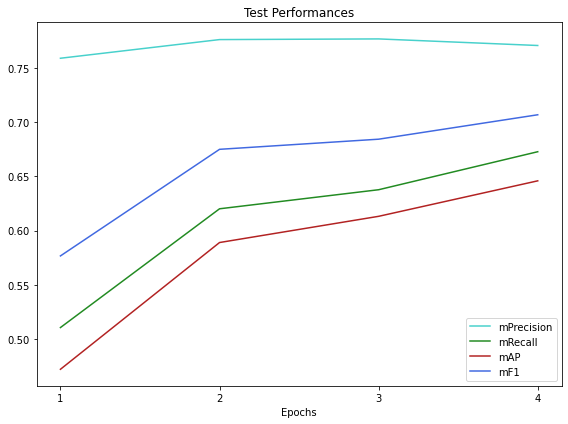

In [14]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

#### Confusion Matrix

In [15]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [16]:
# model prediction to create confusion matrix
dict_ground_truth, dict_result = pred_cm(model,dev_data_loader)

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

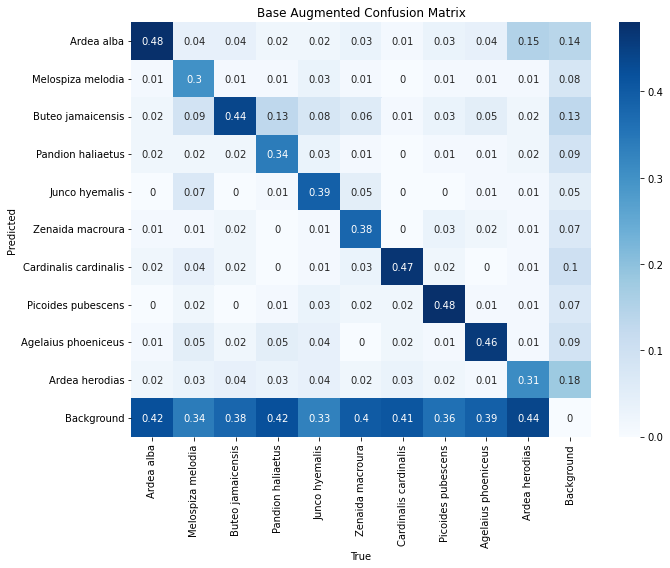

In [17]:
confusion_matrix_aug = create_confusion_matrix(dict_ground_truth, dict_result, 10)

### 4.2 BW Model <a class="anchor" id="bw_m"></a>

In [18]:
model_dir = "Model_Faster/BW"

#### Epochs evaluation

In [19]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir,dev_data_loader_bw)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

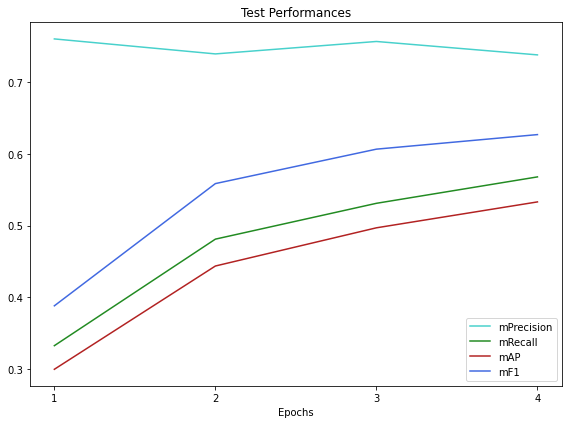

In [20]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

#### Confusion Matrix

In [21]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [22]:
# model prediction to create confusion matrix
dict_ground_truth, dict_result = pred_cm(model, dev_data_loader_bw)

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

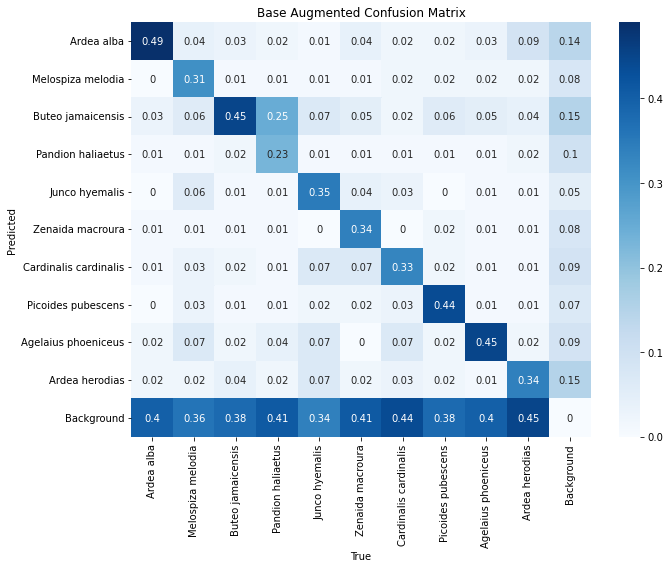

In [23]:
confusion_matrix_BW = create_confusion_matrix(dict_ground_truth, dict_result, 10)

### 4.3 Undersampled Model <a class="anchor" id="under_m"></a>

In [25]:
model_dir = "Model_Faster/Under"

#### Epochs evaluation

In [26]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir, dev_data_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

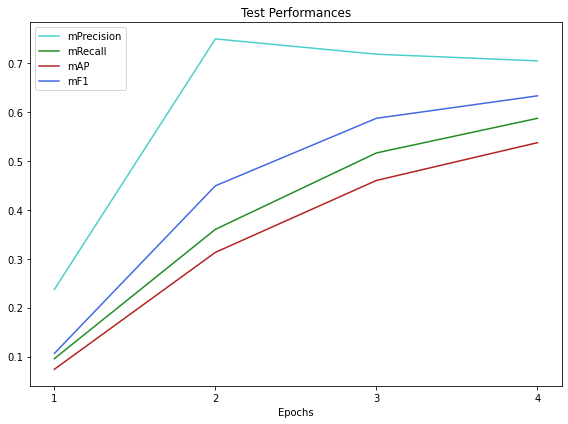

In [27]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

#### Confusion Matrix

In [28]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [29]:
# model prediction to create confusion matrix
dict_ground_truth, dict_result = pred_cm(model, dev_data_loader)

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

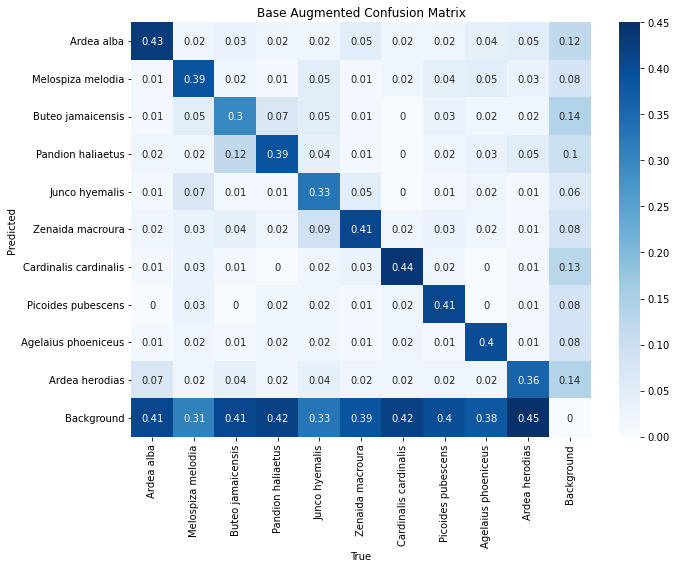

In [30]:
confusion_matrix_under = create_confusion_matrix(dict_ground_truth, dict_result, 10)

### 4.4 Oversampled Model <a class="anchor" id="over_m"></a>

In [31]:
model_dir = "Model_Faster/Over"

#### Epochs evaluation

In [32]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir, dev_data_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

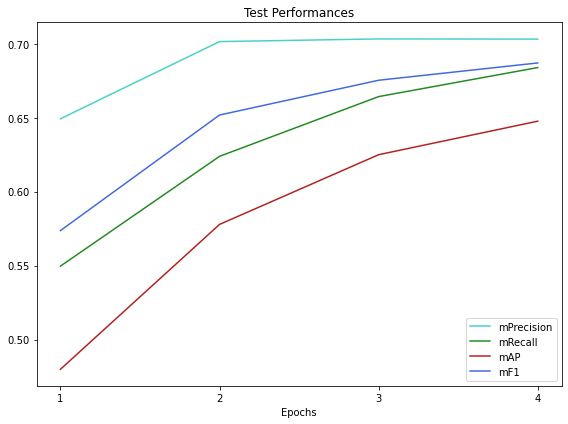

In [33]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

#### Confusion Matrix

In [34]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [35]:
# model prediction to create confusion matrix
dict_ground_truth, dict_result = pred_cm(model, dev_data_loader)

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

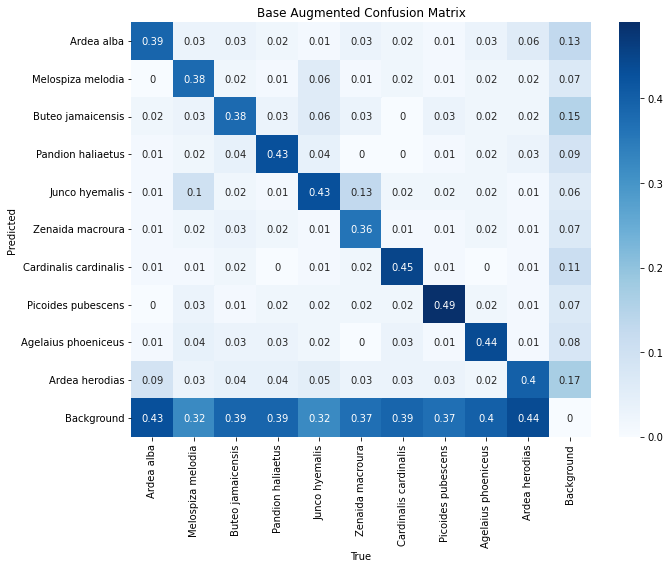

In [36]:
confusion_matrix_over = create_confusion_matrix(dict_ground_truth, dict_result, 10)

### 4.5 Best model trying to predict BW photos <a class="anchor" id="bestVSbw"></a>

In [37]:
model_dir = "Model_Faster/Over"

In [38]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [39]:
# model prediction to create confusion matrix
dict_ground_truth, dict_result = pred_cm(model, dev_data_loader_bw)

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

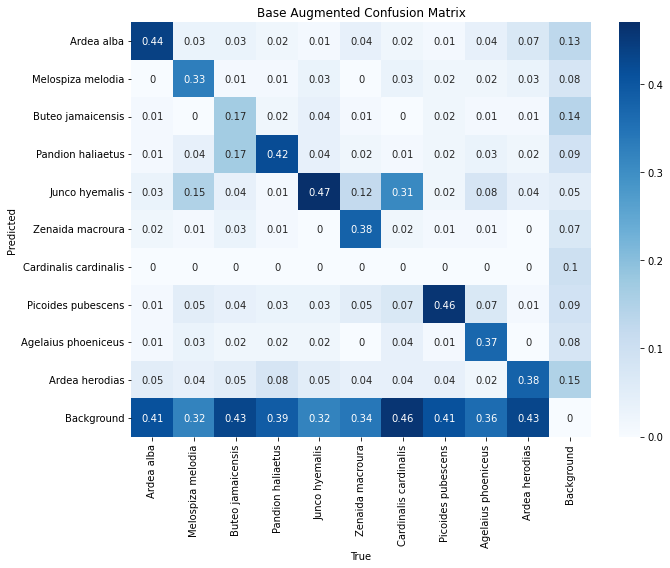

In [40]:
confusion_matrix_ = create_confusion_matrix(dict_ground_truth, dict_result, 10)